In [1]:
import os
import sys
import numpy as np
import pandas as pd
import random

from argparse import ArgumentParser
import datetime

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.backends.cudnn as cudnn

from pytvision.transforms import transforms as mtrans
from pytvision import visualization as view

sys.path.append('../')
from torchlib.datasets.factory  import FactoryDataset 
from torchlib.datasets import Dataset 
from torchlib.neuralnet import NeuralNetClassifier
from misc import get_transforms_det

from sklearn import metrics

In [20]:
pathname = os.path.expanduser( '~/.datasets' )
projectnet='../out/netruns'
name_dataset=FactoryDataset.jaffe
no_cuda=False
seed=1
gpu=1
batch_size=60
workers=10
num_input_channels=3

print(pathname)
print(projectnet)
print(name_dataset)

/root/.datasets
../out/netruns
jaffe


In [3]:
!ls ../out/netruns/

exp_baseline_preactresnet18_cross_sgd_cifar100_aug_001
exp_baseline_preactresnet18_cross_sgd_cifar10_aug_001
exp_baseline_preactresnet18_cross_sgd_cifar10_aug_002
exp_baseline_preactresnet18_cross_sgd_fashion_aug_001
exp_baseline_preactresnet18_cross_sgd_ferp_allaug_002
exp_baseline_preactresnet18_cross_sgd_ferp_aug_002
exp_baseline_preactresnet18_cross_sgd_stl10_aug_001
exp_baseline_preactresnet18_cross_sgd_svhn_aug_001
exp_baseline_preactresnet34_cross_sgd_cifar100_aug_001
exp_baseline_preactresnet34_cross_sgd_cifar10_aug_001


In [4]:
name = 'exp_baseline_preactresnet18_cross_sgd_ferp_allaug_002'
project = os.path.join(projectnet, name)
model = 'model_best.pth.tar' #'chk001025.pth.tar', model_best
pathmodels = os.path.join(project,'models',model)

print(project)
print(pathmodels)

../out/netruns/exp_baseline_preactresnet18_cross_sgd_ferp_allaug_002
../out/netruns/exp_baseline_preactresnet18_cross_sgd_ferp_allaug_002/models/model_best.pth.tar


## Load model

In [5]:
# neuralnet
network = NeuralNetClassifier(
    patchproject=project,
    nameproject=name,
    no_cuda=no_cuda,
    seed=seed,
    gpu=gpu
    )

cudnn.benchmark = True

# load model
if network.load( pathmodels ) is not True:
    assert(False)

Without the incoming socket you cannot receive events from the server or register event handlers to your Visdom client.


=> loading checkpoint '../out/netruns/exp_baseline_preactresnet18_cross_sgd_ferp_allaug_002/models/model_best.pth.tar'
=> loaded checkpoint for preactresnet18 arch!


In [25]:

subset=FactoryDataset.training

data = Dataset(
    data=FactoryDataset.factory(
        pathname=pathname, 
        name=name_dataset, 
        subset=subset, 
        download=True ),
    num_channels=num_input_channels,
    transform=get_transforms_det(network.size_input)
    )

dataloader = DataLoader(data, batch_size=batch_size, shuffle=False, num_workers=workers )

print('Data loader ')
print(len(dataloader))
print(len(data))

Data loader 
4
201


In [26]:
Yhat, Y = network.test( dataloader )
df = pd.DataFrame( np.concatenate((Yhat, Y), axis=1) )
df.to_csv( os.path.join(project , 'val_{}_{}_dp.csv'.format(name,name_dataset)), index=False, encoding='utf-8')       

print('dir: {}'.format(project))
print('DONE!!!')

100%|██████████| 4/4 [00:00<00:00,  4.95it/s]

dir: ../out/netruns/exp_baseline_preactresnet18_cross_sgd_ferp_allaug_002
DONE!!!


In [27]:
df = pd.read_csv( os.path.join(project , 'val_{}_{}_dp.csv'.format(name, name_dataset))  )
df.head()

,0,1,2,3,4,5,6,7,8
0,0.768982,3.397970e-08,1.248818e-08,0.229884,3.942057e-04,7.332308e-05,2.960142e-05,6.371328e-04,4.0
1,0.998841,6.548833e-09,2.984125e-09,0.001147,1.723467e-06,7.154703e-07,3.846847e-07,9.134590e-06,4.0
2,0.000293,6.179817e-13,6.860750e-10,0.999707,4.289341e-12,3.397419e-10,2.656189e-09,1.735064e-09,5.0
3,0.000278,1.582566e-11,1.395382e-08,0.999722,9.570392e-09,1.510710e-07,2.773884e-08,3.094821e-08,5.0
4,0.005153,2.957628e-09,9.594661e-08,0.994685,8.970256e-05,6.633773e-05,2.842201e-06,3.221493e-06,5.0


In [28]:
result = df.as_matrix()
yhat = np.argmax( result[:,:-1], axis=1 )
y = result[:,-1]

acc = metrics.accuracy_score(y, yhat)
precision = metrics.precision_score(y, yhat, average='macro')
recall = metrics.recall_score(y, yhat, average='macro')
f1_score = 2*precision*recall/(precision+recall)

print('Accuracy : %f' % acc)
print('Precision : %f' % precision)
print('Recall : %f' % recall)
print('F1 score : %f' % f1_score)
print("")

Accuracy : 0.383085
Precision : 0.456811
Recall : 0.367730
F1 score : 0.407459



In [29]:
metric = metrics.classification_report(y, yhat)
print(metric)

             precision    recall  f1-score   support

        0.0       0.25      1.00      0.40        30
        1.0       0.95      0.65      0.77        31
        2.0       1.00      0.35      0.51        26
        3.0       0.33      0.52      0.40        31
        4.0       0.00      0.00      0.00        25
        5.0       0.00      0.00      0.00        28
        6.0       0.67      0.07      0.12        30

avg / total       0.46      0.38      0.33       201



In [31]:
mc = metrics.confusion_matrix(y, yhat)
print(mc)

[[30  0  0  0  0  0  0]
 [11 20  0  0  0  0  0]
 [13  1  9  2  0  0  1]
 [15  0  0 16  0  0  0]
 [24  0  0  1  0  0  0]
 [11  0  0 17  0  0  0]
 [15  0  0 13  0  0  2]]


Normalized confusion matrix


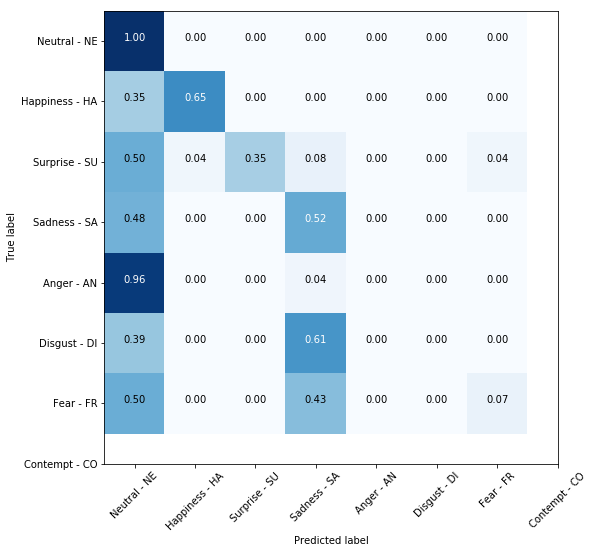

In [32]:
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


plt.figure( figsize=(8,8))
plot_confusion_matrix(mc, classes=data.data.classes, title=' ')
plt.show()